# IMPORT DATA



The purpose of this notebook is to create a prediction model, which takes into account the metadata about patient and the samples as the ECG curves. Targets for the model will be superclasses as defined by the dataset.

Superclasses enumerated by dataset description are as follows:
```
Records | Superclass | Description
9528 | NORM | Normal ECG
5486 | MI | Myocardial Infarction
5250 | STTC | ST/T Change
4907 | CD | Conduction Disturbance
2655 | HYP | Hypertrophy
```

In [12]:
import torch
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
import os
import ast
import wfdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras as keras

sns.set_style('darkgrid')

In [15]:
PATH_TO_DATA = '../ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'

ECG_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'ptbxl_database.csv'), index_col='ecg_id')
ECG_df.scp_codes = ECG_df.scp_codes.apply(lambda x: ast.literal_eval(x))
ECG_df.patient_id = ECG_df.patient_id.astype(int)
ECG_df.nurse = ECG_df.nurse.astype('Int64')
ECG_df.site = ECG_df.site.astype('Int64')
ECG_df.validated_by = ECG_df.validated_by.astype('Int64')

SCP_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'scp_statements.csv'), index_col=0)
SCP_df = SCP_df[SCP_df.diagnostic == 1]

half_rows = len(ECG_df) // 2
ECG_df = ECG_df.iloc[half_rows:]
ECG_df

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
10919,20855,74.0,0,NaN,NaN,1,2,CS-12,1993-09-04 12:09:33,vorhofflimmern/-flattern linkstyp linksschenke...,...,True,", V3",", alles,",NaN,NaN,1ES,NaN,9,records100/10000/10919_lr,records500/10000/10919_hr
10920,891,61.0,0,190.0,95.0,8,1,AT-6 C 5.5,1993-09-04 13:05:05,sinus rhythm. normal ecg.,...,True,NaN,NaN,NaN,NaN,NaN,NaN,1,records100/10000/10920_lr,records500/10000/10920_hr
10921,5577,70.0,1,170.0,77.0,3,1,AT-6 C 5.5,1993-09-04 13:07:21,sinus rhythm. prolonged pr interval. r-s trans...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,1,records100/10000/10921_lr,records500/10000/10921_hr
10922,14293,45.0,0,NaN,NaN,0,0,CS100 3,1993-09-04 13:20:28,sinusrhythmus linkstyp unspezifischer intraven...,...,False,NaN,NaN,NaN,NaN,NaN,NaN,8,records100/10000/10922_lr,records500/10000/10922_hr
10923,5849,74.0,0,178.0,71.0,4,1,AT-6 C 5.5,1993-09-04 13:36:57,sinus rhythm. no definite pathology.,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/10000/10923_lr,records500/10000/10923_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180,67.0,1,NaN,NaN,1,2,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703,93.0,0,NaN,NaN,1,2,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311,59.0,1,NaN,NaN,1,2,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


In [16]:
def diagnostic_class(scp):
    res = set()
    for k in scp.keys():
        if k in SCP_df.index:
            res.add(SCP_df.loc[k].diagnostic_class)
    return list(res)
                    
ECG_df['scp_classes'] = ECG_df.scp_codes.apply(diagnostic_class)

In [8]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

sampling_rate = 100

ECG_data = load_raw_data(ECG_df, sampling_rate, PATH_TO_DATA)

ECG_data.shape

(10919, 1000, 12)

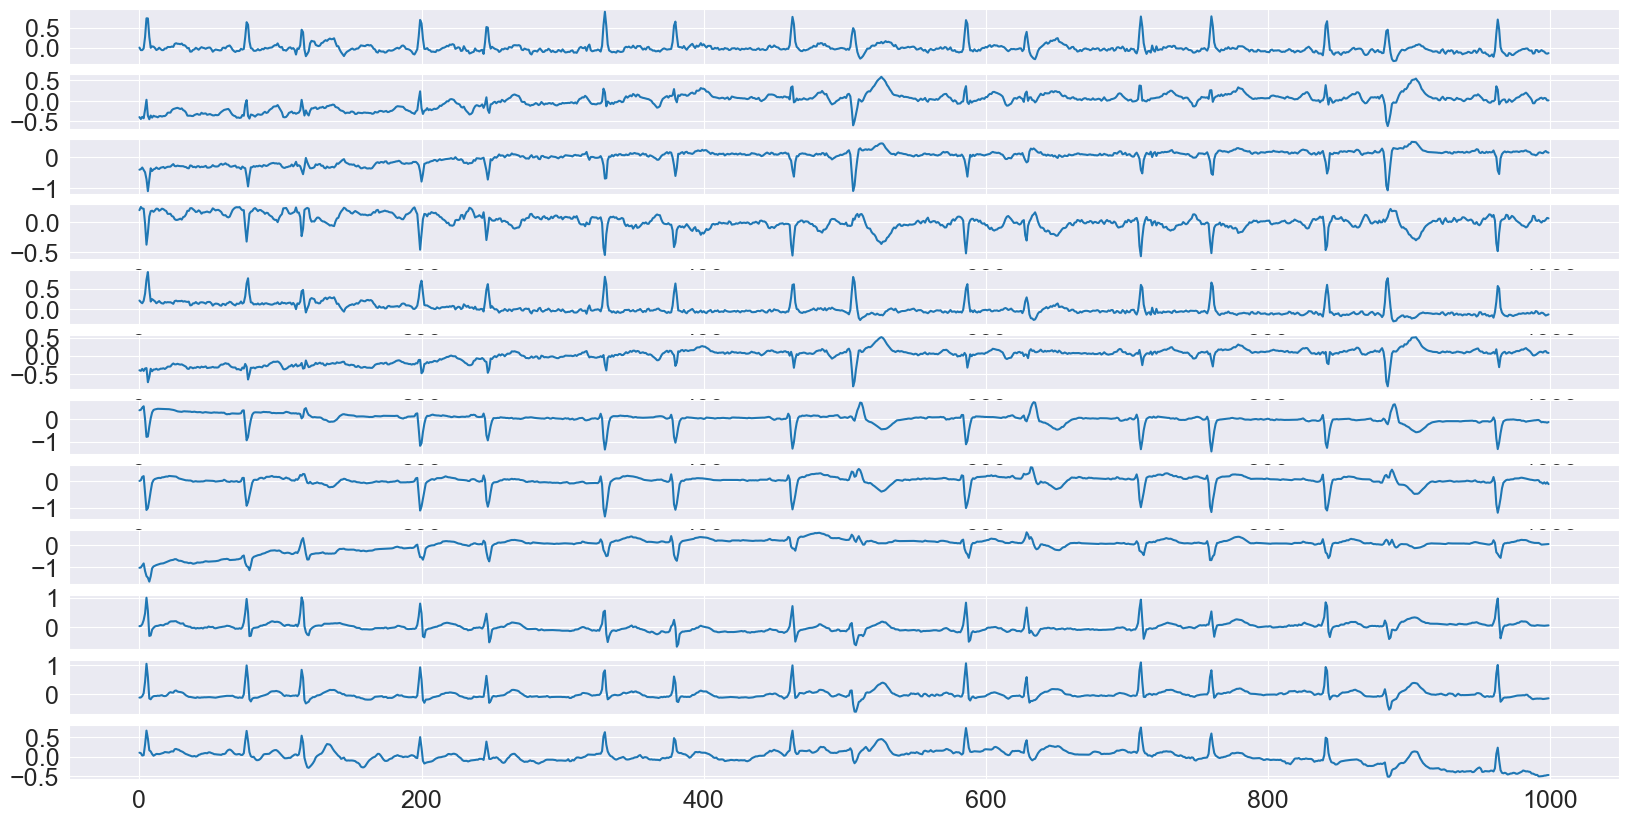

In [9]:
sample = ECG_data[0]  # Pastikan ECG_data sudah ada dalam lingkungan Anda
bar, axes = plt.subplots(sample.shape[1], 1, figsize=(20, 10))

for i in range(sample.shape[1]):
    sns.lineplot(x=np.arange(sample.shape[0]), y=sample[:, i], ax=axes[i])

# Perbesar angka pada sumbu X dan Y
for ax in axes:
    ax.tick_params(axis='both', labelsize=18)  # Mengatur ukuran font untuk sumbu X dan Y

plt.show()

In [10]:
ECG_df[[col for col in ECG_df.columns if col not in ('scp_codes', 'scp_classes')]].nunique(dropna=True)

patient_id                       9228
age                                90
sex                                 2
height                             63
weight                            107
nurse                              12
site                               49
device                             11
recording_date                  10908
report                           5312
heart_axis                          8
infarction_stadium1                 6
infarction_stadium2                 3
validated_by                       12
second_opinion                      2
initial_autogenerated_report        2
validated_by_human                  2
baseline_drift                    182
static_noise                       90
burst_noise                        73
electrodes_problems                 6
extra_beats                       100
pacemaker                           2
strat_fold                         10
filename_lr                     10919
filename_hr                     10919
dtype: int64

# Data preparation for modeling

## X dataframe (metadata)

In [11]:
X = pd.DataFrame(index=ECG_df.index)

X['age'] = ECG_df.age
X.age.fillna(0, inplace=True)

X['sex'] = ECG_df.sex.astype(float)
X.sex.fillna(0, inplace=True)

X['height'] = ECG_df.height
X.loc[X.height < 50, 'height'] = np.nan
X.height.fillna(0, inplace=True)

X['weight'] = ECG_df.weight
X.weight.fillna(0, inplace=True)

X['infarction_stadium1'] = ECG_df.infarction_stadium1.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium I-II': 2,
    'Stadium II': 3,
    'Stadium II-III': 4,
    'Stadium III': 5
}).fillna(0)

X['infarction_stadium2'] = ECG_df.infarction_stadium2.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium II': 2,
    'Stadium III': 3
}).fillna(0)

X['pacemaker'] = (ECG_df.pacemaker == 'ja, pacemaker').astype(float)

X

C:\Users\oc\AppData\Local\Temp\ipykernel_14704\3316299910.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X.age.fillna(0, inplace=True)
C:\Users\oc\AppData\Local\Temp\ipykernel_14704\3316299910.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col]

,age,sex,height,weight,infarction_stadium1,infarction_stadium2,pacemaker
ecg_id,,,,,,,
10919,74.0,0.0,0.0,0.0,0.0,0.0,0.0
10920,61.0,0.0,190.0,95.0,0.0,0.0,0.0
10921,70.0,1.0,170.0,77.0,0.0,0.0,0.0
10922,45.0,0.0,0.0,0.0,0.0,0.0,0.0
10923,74.0,0.0,178.0,71.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
21833,67.0,1.0,0.0,0.0,0.0,0.0,0.0
21834,93.0,0.0,0.0,0.0,4.0,0.0,0.0
21835,59.0,1.0,0.0,0.0,0.0,0.0,0.0


## Y dataframe (raw signal)

## Z targets (target)

In [17]:
Z = pd.DataFrame(0, index=ECG_df.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')
for i in Z.index:
    for k in ECG_df.loc[i].scp_classes:
        Z.loc[i, k] = 1

Z

,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
10919,0,1,0,0,0
10920,1,0,0,0,0
10921,0,0,1,0,1
10922,0,0,0,1,0
10923,0,0,1,0,1
...,...,...,...,...,...
21833,0,0,1,0,0
21834,1,0,0,0,0
21835,0,0,1,0,0


## Splitting to train, validate and test datasets

As the authors of PTB-XL ECG dataset suggest, I will split all input and output dataset to training, validation and test subsets according *strat_fold* column.

In [18]:
from sklearn.model_selection import train_test_split
X_train, Y_train, Z_train = X[ECG_df.strat_fold <= 10],  ECG_data[X[ECG_df.strat_fold <= 10].index - 10919],  Z[ECG_df.strat_fold <= 10]
mask_train = (Z_train['NORM'] == 1) | (Z_train['MI'] == 1)
X_train_filtered = X_train[mask_train]
Y_train_filtered = Y_train[mask_train]
Z_train_filtered = Z_train[mask_train].drop(columns=['STTC', 'CD', 'HYP'])

X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(
    X_train_filtered, Y_train_filtered, Z_train_filtered, test_size=0.1, random_state=42
)
print(X_train.shape, Y_train.shape, Z_train.shape)
print(X_test.shape,  Y_test.shape,  Z_test.shape)

(6682, 7) (6682, 1000, 12) (6682, 2)
(743, 7) (743, 1000, 12) (743, 2)


In [19]:
from sklearn.preprocessing import StandardScaler

# Step 1: Initialize the scaler
X_scaler = StandardScaler()

# Step 2: Fit the scaler only on the X_train data
X_scaler.fit(X_train)

# Step 3: Transform the training, validation, and test sets using the fitted scaler
X_train_scaled = pd.DataFrame(X_scaler.transform(X_train), columns=X_train.columns)
X_test_scaled  = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns)

# Check the shapes to ensure everything is scaled correctly
print("Scaled Train shape:", X_train_scaled.shape)
print("Scaled Test shape:", X_test_scaled.shape)

Scaled Train shape: (6682, 7)
Scaled Test shape: (743, 7)


In [20]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler for Y data
Y_scaler = StandardScaler()

# Step 1: Fit the scaler only on the Y_train data
Y_scaler.fit(Y_train.reshape(-1, Y_train.shape[-1]))

# Step 2: Transform the training, validation, and test sets
Y_train_scaled = Y_scaler.transform(Y_train.reshape(-1, Y_train.shape[-1])).reshape(Y_train.shape)
Y_test_scaled  = Y_scaler.transform(Y_test.reshape(-1, Y_test.shape[-1])).reshape(Y_test.shape)

# Check the shapes to ensure everything is scaled correctly
print("Scaled Train Y shape:", Y_train_scaled.shape)
print("Scaled Test Y shape:", Y_test_scaled.shape)


Scaled Train Y shape: (6682, 1000, 12)
Scaled Test Y shape: (743, 1000, 12)


In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Prepare data
# Ensure the input is 3D (samples, timesteps, features) for LSTM

X_train = Y_train_scaled  # Using the signal data as X
X_test  = Y_test_scaled

# Z is the target (NORM, MI)
y_train = Z_train[['NORM', 'MI']].values
y_test  = Z_test[['NORM', 'MI']].values




In [25]:
from tensorflow.keras.models import load_model
# Path to your model files
lstm_model_path = 'modelResult/best_lstm_model_fold_'
stacked_lstm_model_path = 'modelResult/best_stacked_lstm_model_fold_'
bi_lstm_model_path = 'modelResult/best_bi_lstm_model_fold_'

In [23]:
from sklearn.model_selection import train_test_split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train,  test_size=0.2, random_state=42,  shuffle=True 
)


In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Membuat objek StratifiedKFold dengan 5 fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Variabel untuk menyimpan hasil fold
folds = []

# Melakukan pembagian data ke dalam 5 fold
for train_index, val_index in kf.split(X_train, np.argmax(y_train, axis=1)):  # Pastikan menggunakan y_train, bukan y_test
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Menyimpan fold hasil pemisahan
    folds.append((X_train_fold, X_val_fold, y_train_fold, y_val_fold))

    # Anda bisa melakukan pelatihan model atau evaluasi pada tiap fold disini
    # Misalnya:
    # model.fit(X_train_fold, y_train_fold)
    # model.score(X_val_fold, y_val_fold)

# Output folds (sebagai contoh)
for i, (X_train_fold, X_val_fold, y_train_fold, y_val_fold) in enumerate(folds):
    print(f"Fold {i+1}:")
    print(f"X_train_fold shape: {X_train_fold.shape}, y_train_fold shape: {y_train_fold.shape}")
    print(f"X_val_fold shape: {X_val_fold.shape}, y_val_fold shape: {y_val_fold.shape}")
    print("="*50)

Fold 1:
X_train_fold shape: (5345, 1000, 12), y_train_fold shape: (5345, 2)
X_val_fold shape: (1337, 1000, 12), y_val_fold shape: (1337, 2)
Fold 2:
X_train_fold shape: (5345, 1000, 12), y_train_fold shape: (5345, 2)
X_val_fold shape: (1337, 1000, 12), y_val_fold shape: (1337, 2)
Fold 3:
X_train_fold shape: (5346, 1000, 12), y_train_fold shape: (5346, 2)
X_val_fold shape: (1336, 1000, 12), y_val_fold shape: (1336, 2)
Fold 4:
X_train_fold shape: (5346, 1000, 12), y_train_fold shape: (5346, 2)
X_val_fold shape: (1336, 1000, 12), y_val_fold shape: (1336, 2)
Fold 5:
X_train_fold shape: (5346, 1000, 12), y_train_fold shape: (5346, 2)
X_val_fold shape: (1336, 1000, 12), y_val_fold shape: (1336, 2)


# LSTM


Processing Fold 1

42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step


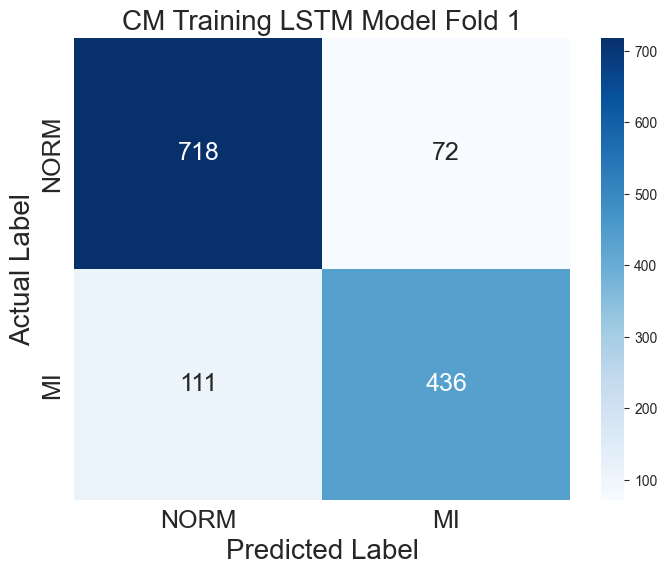


Processing Fold 2

42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step


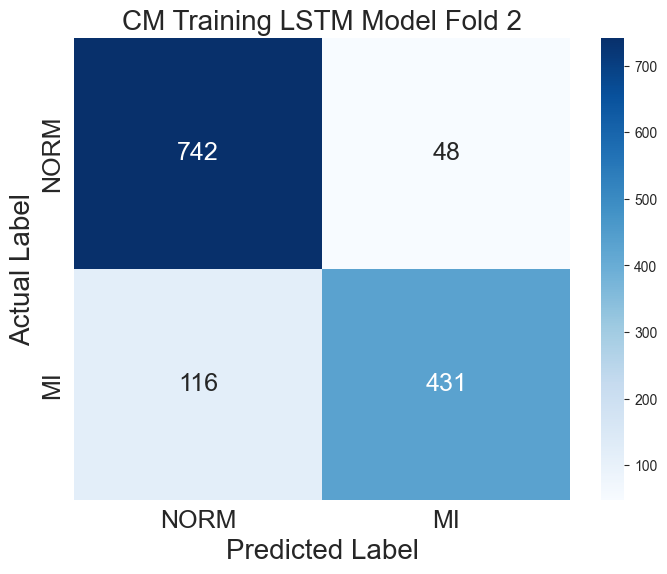


Processing Fold 3

42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step


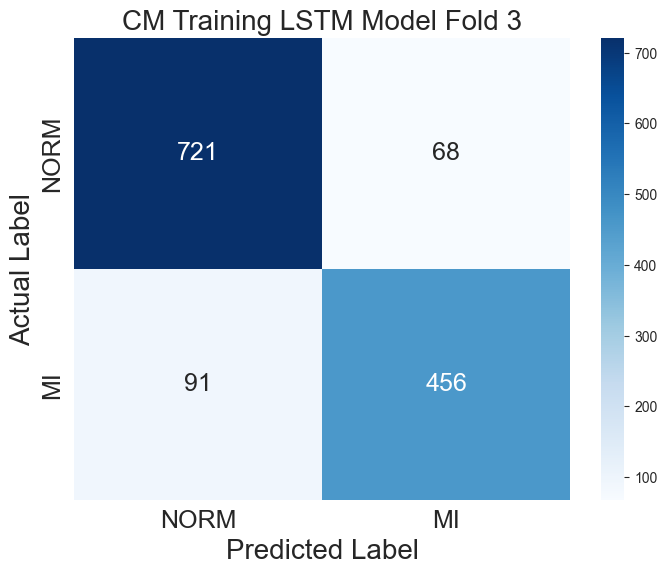


Processing Fold 4

42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step


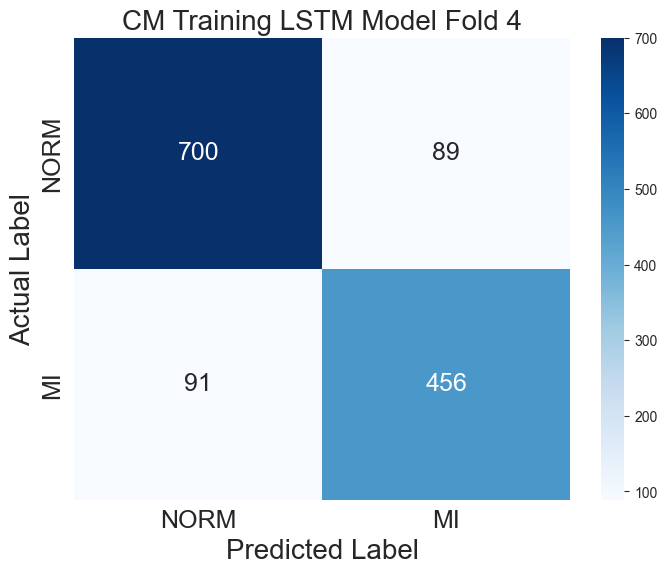


Processing Fold 5

42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step


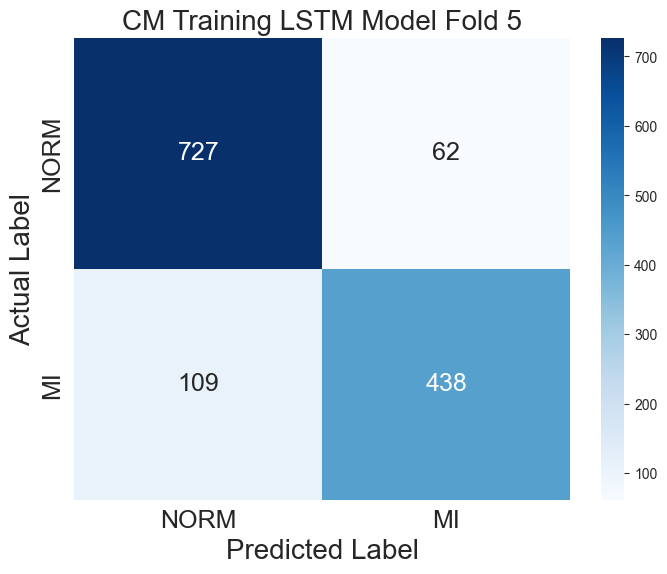

In [26]:
# Placeholder untuk hasil fold
fold_metrics = []

# Step 1: Define Cross-Validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds
fold = 0


# Loop untuk setiap fold
for train_index, valid_index in kf.split(X_train, np.argmax(y_train, axis=1)):
    fold += 1
    print(f"\nProcessing Fold {fold}\n")

    # Split the data into training and validation sets for the current fold
    X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
    y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]

    # Load pre-trained model for each fold
    pretrained_lstm_model = load_model(lstm_model_path+f'{fold}.keras')


    # Step 9: Confusion Matrix on the training set
    y_valid_pred = pretrained_lstm_model.predict(X_valid_fold)
    y_valid_pred_classes = np.argmax(y_valid_pred, axis=1)
    y_valid_true_classes = np.argmax(y_valid_fold, axis=1)
    
    cm_train = confusion_matrix(y_valid_true_classes, y_valid_pred_classes)
    labels = ['NORM', 'MI']
    
    # Plot training confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title(f'CM Training LSTM Model Fold {fold}', fontsize=20)
    plt.ylabel('Actual Label', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(f'image/confusion_matrix_training_lstm_model_fold_{fold}.png', dpi=300)
    plt.show()
    plt.close()
    



# STACKED LSTM


Processing Fold 1

42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step


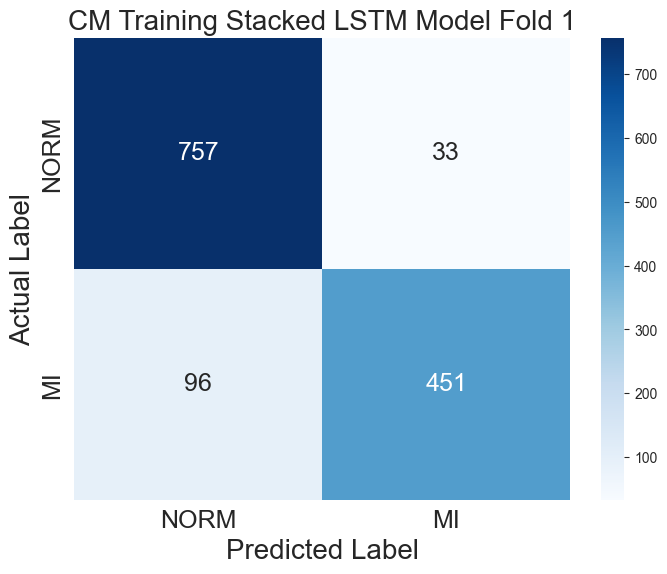


Processing Fold 2

42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step


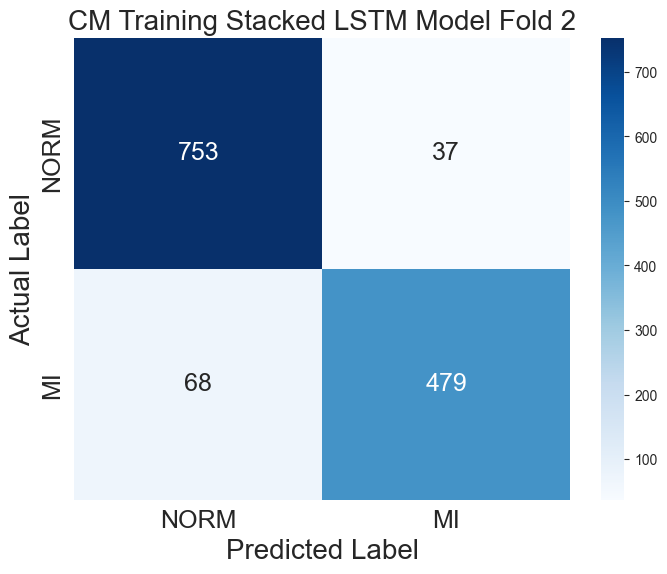


Processing Fold 3

42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step


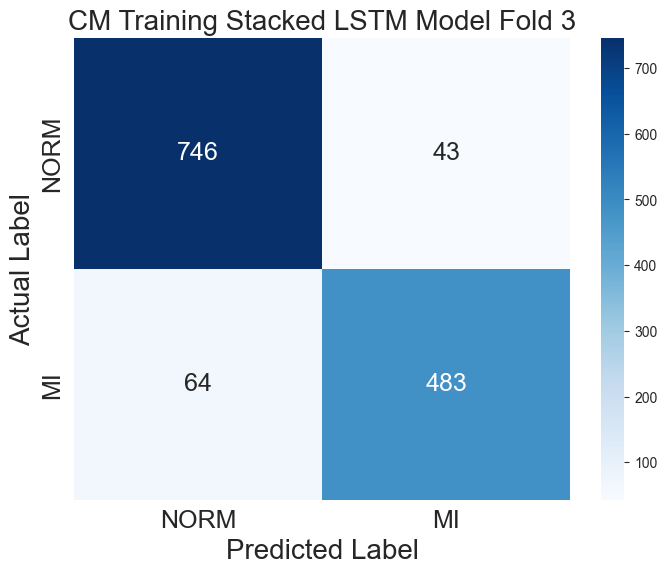


Processing Fold 4

42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step


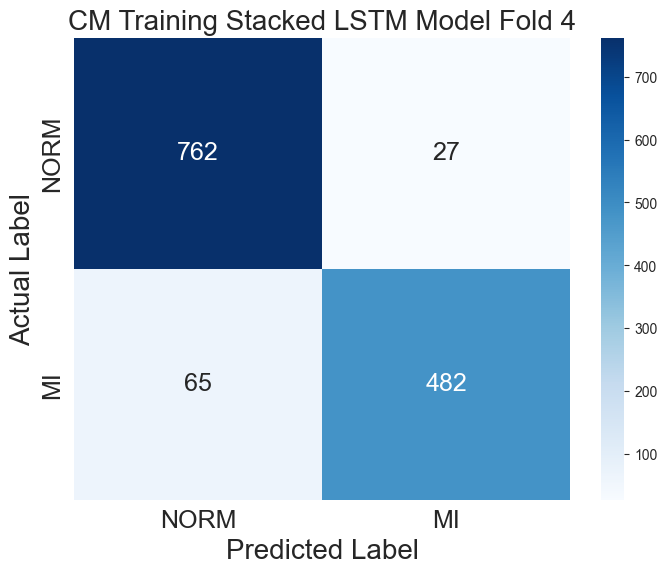


Processing Fold 5

42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step


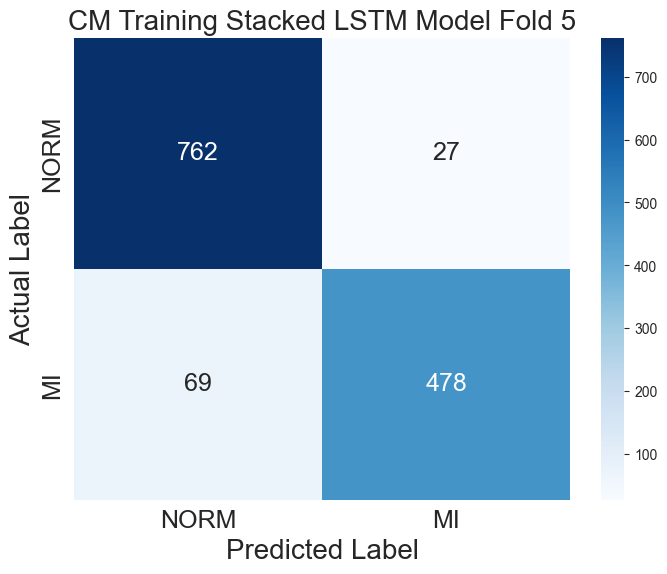

In [27]:
# Placeholder untuk hasil fold
fold_metrics = []

# Step 1: Define Cross-Validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds
fold = 0


# Loop untuk setiap fold
for train_index, valid_index in kf.split(X_train, np.argmax(y_train, axis=1)):
    fold += 1
    print(f"\nProcessing Fold {fold}\n")

    # Split the data into training and validation sets for the current fold
    X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
    y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]

    # Load pre-trained model for each fold
    pretrained_lstm_model = load_model(stacked_lstm_model_path+f'{fold}.keras')


    # Step 9: Confusion Matrix on the training set
    y_valid_pred = pretrained_lstm_model.predict(X_valid_fold)
    y_valid_pred_classes = np.argmax(y_valid_pred, axis=1)
    y_valid_true_classes = np.argmax(y_valid_fold, axis=1)
    
    cm_train = confusion_matrix(y_valid_true_classes, y_valid_pred_classes)
    labels = ['NORM', 'MI']
    
    # Plot training confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title(f'CM Training Stacked LSTM Model Fold {fold}', fontsize=20)
    plt.ylabel('Actual Label', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(f'image/confusion_matrix_training_stacked_lstm_model_fold_{fold}.png', dpi=300)
    plt.show()
    plt.close()


# BI LSTM


Processing Fold 1

42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 250ms/step


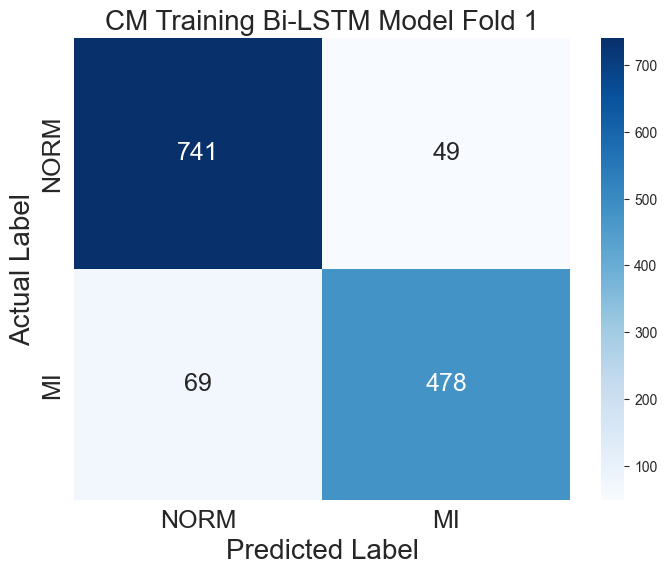


Processing Fold 2

42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 246ms/step


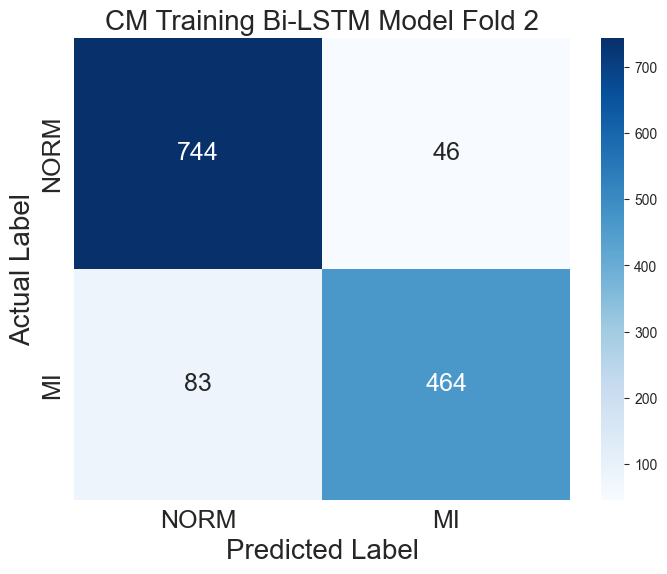


Processing Fold 3

42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step


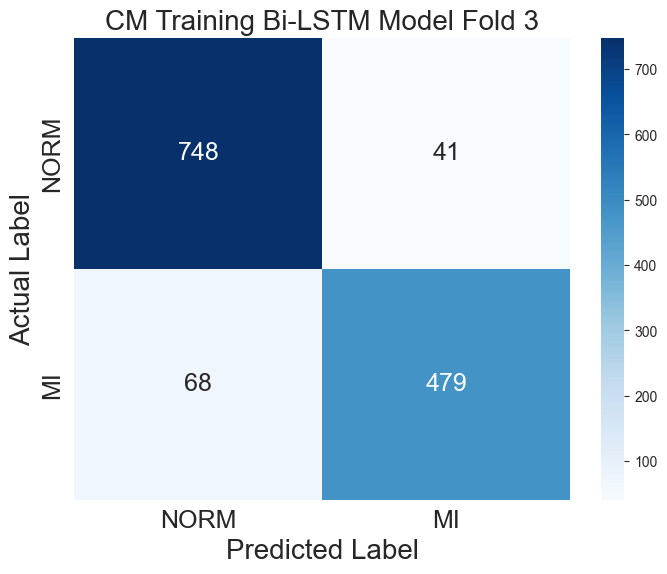


Processing Fold 4

42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 262ms/step


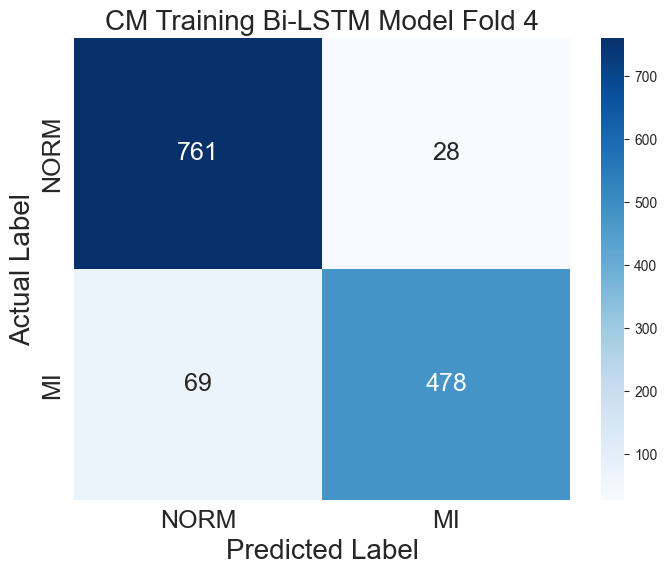


Processing Fold 5

42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step


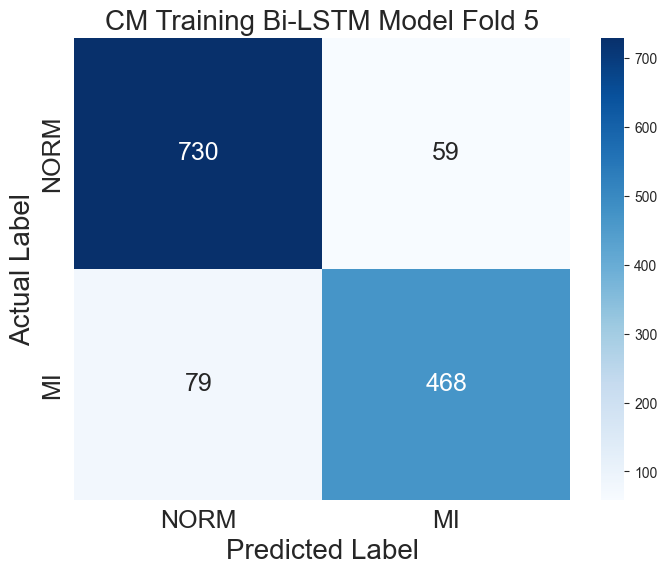

In [28]:
# Placeholder untuk hasil fold
fold_metrics = []

# Step 1: Define Cross-Validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds
fold = 0


# Loop untuk setiap fold
for train_index, valid_index in kf.split(X_train, np.argmax(y_train, axis=1)):
    fold += 1
    print(f"\nProcessing Fold {fold}\n")

    # Split the data into training and validation sets for the current fold
    X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
    y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]

    # Load pre-trained model for each fold
    pretrained_lstm_model = load_model(bi_lstm_model_path+f'{fold}.keras')


    # Step 9: Confusion Matrix on the training set
    y_valid_pred = pretrained_lstm_model.predict(X_valid_fold)
    y_valid_pred_classes = np.argmax(y_valid_pred, axis=1)
    y_valid_true_classes = np.argmax(y_valid_fold, axis=1)
    
    cm_train = confusion_matrix(y_valid_true_classes, y_valid_pred_classes)
    labels = ['NORM', 'MI']
    
    # Plot training confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title(f'CM Training Bi-LSTM Model Fold {fold}', fontsize=20)
    plt.ylabel('Actual Label', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(f'image/confusion_matrix_training_bi_lstm_model_fold_{fold}.png', dpi=300)
    plt.show()
    plt.close()

# END
